# 10-minutes to scikit-learn
The objective of this ipython notebook is to present a short overview of the scikit-learn python module features and apply the principal steps of machine learning to predict the temperature of the city of Sao Paulo from the varaibles from a global climatic model

For more informatiion about sklearn, check the user guide: http://scikit-learn.org/stable/user_guide.html

Disclaimer: The code used in this application is only for teaching purpose.


## The short description
scikit-learn is the "must-know"machine learning modulefor Python. It includes simple and efficient tools build on top numpy, scipy and matplotlib.

Scikit-learn is largely written in Python, with some core algorithms written in Cython to achieve performance

## Available tools
* Supervised learning
  * Models:GLM, SVM, SGD, Ensemble method (random forest, gradient boosting), NN ...
* Unsupervised learning
  * Models: PCA, kernel PCA, clustering, NN,
* Dimensionality reduction
  * PCA, ICA, Kernel PCA, factor analysis
  * feature selection
* Model selection and evaluation
  * Cross-validation
  * Hyper-parameters optimization
  * Model evaluation: metrics
* Dataset transformation
  * Feature extraction
  * Preprocessing
  * Pipeline

# Application: Prediction of local surface temperature from large scale model

The objective here is to predict the temperature over Sao Paulo in function of the climatic variables from large scale climatic models using sklearn 

### Dataset
In the folder **data** of this repository you will find two dataset
* df_sta_temp.csv : Data of surface station temperature in Sao Paulo

* dataset_GFS_variables.csv: Climatic variables from Global Climate Models at the nearest grid point to SP.




In [107]:
# import libraries
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [108]:
df_sta = pd.read_csv('./data/df_sta_temp.csv', index_col=0, parse_dates=True)
df_gfs = pd.read_csv('./data/df_gfs.csv', index_col=0, parse_dates=True)

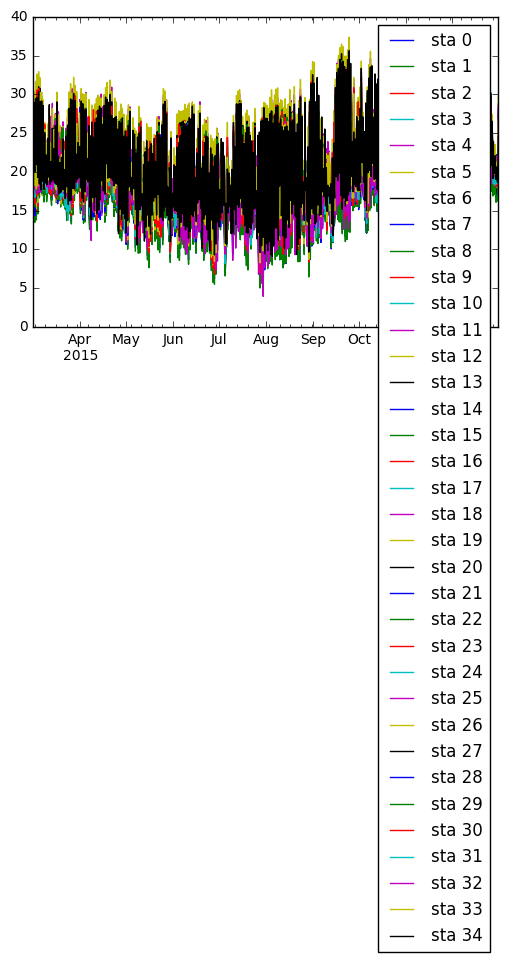

In [109]:
df_sta.plot(label=None)

## Preprocessing



Prepocessing methods suchs as normalization and standardization is often required by machine learning estimators.
Scikit learn offer a lot of tools for preprocessing.

In [115]:
dir(preprocessing)

['Binarizer',
 'FunctionTransformer',
 'Imputer',
 'KernelCenterer',
 'LabelBinarizer',
 'LabelEncoder',
 'MaxAbsScaler',
 'MinMaxScaler',
 'MultiLabelBinarizer',
 'Normalizer',
 'OneHotEncoder',
 'PolynomialFeatures',
 'RobustScaler',
 'StandardScaler',
 '__all__',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 '_function_transformer',
 'add_dummy_feature',
 'binarize',
 'data',
 'imputation',
 'label',
 'label_binarize',
 'maxabs_scale',
 'minmax_scale',
 'normalize',
 'robust_scale',
 'scale']

In [110]:
from sklearn import preprocessing

In [111]:
# standardization
df_sta_scaled = preprocessing.scale(df_sta)
df_gfs_scaled = preprocessing.scale(df_gfs)

In [112]:
df_sta_scaled.mean()

1.5875890979396294e-17

In [113]:
df_sta_scaled.std()

1.0000000000000013

## Dimensionality reduction 

If your dataset present a high number of features (variables) with a lot colinearity. Thus it might be useful to use an unsupervised dimensionality reduction method.
Here we will use Principal Component Analysis (PCA).

In [34]:
from sklearn.decomposition import PCA # import Principal Component Analysis

In [35]:
pca = PCA(n_components=6) # Create the model (unsupervised learning)

In [42]:
pca.fit(df_sta_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
df_sta_reduced = pca.transform(df_sta_scaled) #apply the transformation to the original dataset

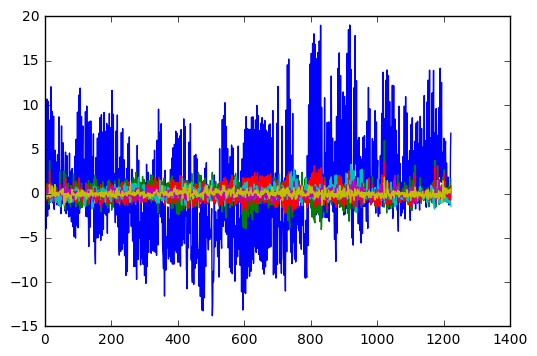

In [44]:
plt.plot(df_sta_reduced)

In [48]:
pca.explained_variance_ratio_ * 100

array([ 91.05342951,   3.37294731,   2.12722218,   1.11429096,
         0.43661138,   0.28513872])

## Cross-validation: evaluating estimator performance


It is well know that learning the parameters of a model and testing it on the same dataset is a metodological mistake which can lead to overfitting.
To avoid it, a common techniques consist in spliting the original dataset in subsets and train and test the model on individual subsets. It exists several methods for cross validation see: http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html 

In [49]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_gfs_scaled, df_sta_reduced, test_size=0.4, random_state=0)

In [53]:
X_train.shape

(733, 186)

In [55]:
y_test.shape

(490, 6)

## Random Forest ensemble model
Now lets try to predict the first principal component of the station temperature with the large scale model variables.

In [118]:
from sklearn.ensemble import RandomForestRegressor

### Model Training (supervised learning)

In [119]:

max_depth = 30 # maximum depth of the tree
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2) # create the model
regr_rf.fit(X_train, y_train) # train the model 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

### Model prediction 

In [120]:
y_rf_estimated = regr_rf.predict(X_test)

### Model validation

In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [122]:
mean_absolute_error(y_test, y_rf_estimated)

0.54713712862236952

In [123]:
mean_squared_error(y_test, y_rf_estimated)

0.73302242800884054

## Glue it with Pipeline



In [124]:
from sklearn.pipeline import Pipeline

In [125]:
estimators = [('reduce_dim', PCA()), ('rf', RandomForestRegressor())]

In [126]:
pipe = Pipeline(estimators)

In [127]:
pipe

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_s...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [128]:
predicted = pipe.fit(X_train, y_train).predict(X_test)

In [129]:
mean_absolute_error(y_test, y_rf_estimated)

0.54713712862236952

## Available Datasets

http://scikit-learn.org/stable/datasets/index.html

## Bonus

https://www.kaggle.com/jeffd23/10-classifier-showdown-in-scikit-learn